<a href="https://colab.research.google.com/github/AndreParise/Classifica-o-de-Imagens-com-Transfer-Learning-Aprendizado-por-Transfer-ncia-/blob/main/transfer_learning_original_Andre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Classificação de Imagens com Transfer Learning (Aprendizado por Transferência)**

Este projeto tem como objetivo demonstrar o uso de **aprendizado por transferência** (Transfer Learning) para criar um **classificador de imagens eficiente**, mesmo com um número relativamente pequeno de dados de treinamento. A técnica se baseia na reutilização de modelos de redes neurais já treinados em grandes bases de dados (como o ImageNet), aproveitando o conhecimento previamente adquirido para resolver novos problemas de classificação.

### **O que foi feito no projeto**

Inicialmente, foi desenvolvido um modelo de rede neural convolucional (CNN) **customizado do zero**, treinado com imagens pré-processadas para reconhecer diferentes categorias. Esse modelo já obteve bons resultados, mas seu desempenho é limitado quando se trabalha com bases de dados pequenas ou específicas.

Para superar essa limitação, foi implementado o **Transfer Learning** utilizando o modelo **VGG16**, uma arquitetura consagrada que teve ótimo desempenho no desafio de classificação de imagens do ImageNet. A abordagem adotada incluiu:

* **Carregamento do modelo VGG16 pré-treinado**, com pesos treinados em milhões de imagens.
* **Substituição da camada final (softmax de 1000 classes)** por uma nova camada densa adaptada ao número de classes do nosso conjunto.
* **Congelamento das camadas iniciais**, que são responsáveis por extrair características genéricas (bordas, texturas, padrões).
* **Treinamento da nova camada final** com uma taxa de aprendizado baixa, prática conhecida como *fine-tuning*.

Além disso, o desempenho do modelo com Transfer Learning foi **comparado com o modelo básico**, utilizando métricas de perda (loss) e acurácia durante o treinamento e validação.

### **Resultados Esperados e Observados**

Ao comparar as abordagens, observamos que o modelo com Transfer Learning **superou significativamente o modelo treinado do zero**, alcançando melhor acurácia e generalização, mesmo com uma quantidade limitada de dados.

Essa melhoria se deve ao fato de que redes neurais profundas já treinadas em grandes conjuntos de dados conseguem **extrair características visuais universais**, que ainda são úteis mesmo em novos contextos.

Por fim, o projeto permite testar o modelo em **novas imagens individuais**, exibindo a predição visualmente e apresentando as probabilidades de classificação para cada classe, tornando a aplicação prática e intuitiva.


In [ ]:
# BLOCO 1:

%matplotlib inline
import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from PIL import Image
from tqdm import tqdm  # Para a barra de progresso
import sys  # Para sys.stderr

### Getting a dataset


   !wget -q --show-progress https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip



In [ ]:
# BLOCO 2:

# Download silencioso com tratamento robusto de erros
!wget -q --show-progress https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip || (echo "Download falhou! Verifique sua conexão." && exit 1)

# Extração segura (só executa se o download foi bem-sucedido)
if os.path.exists('kagglecatsanddogs_5340.zip'):
    !unzip -q -o kagglecatsanddogs_5340.zip && rm kagglecatsanddogs_5340.zip
    print("Extração concluída com sucesso!")
else:
    raise FileNotFoundError("Arquivo ZIP não encontrado após download!")

# Verificação eficiente do diretório
dataset_dir = "PetImages"
if not os.path.exists(dataset_dir):
    raise NotADirectoryError(f"Diretório {dataset_dir} não encontrado!")
else:
    # Lista apenas 2 arquivos para verificação (economiza RAM)
    print("\nEstrutura do diretório:")
    !ls {dataset_dir} | head -n 2

kagglecatsanddogs_5 100%[===================>] 786.67M  60.5MB/s    in 13s     
Extração concluída com sucesso!

Estrutura do diretório:
Cat
Dog


In [ ]:
# BLOCO 3:

# --- configurações ---
root = 'PetImages'
train_split = 0.7    # 70% treino
val_split = 0.15     # 15% validação
test_split = 0.15    # 15% teste

# --- validações iniciais ---
if not os.path.exists(root):
    raise FileNotFoundError(f"Diretório '{root}' não encontrado! Verifique o caminho.")

# verifica splits com tolerância para arredondamento
total_split = train_split + val_split + test_split
if abs(total_split - 1.0) > 0.01:  # tolerância de 1%
    raise ValueError(f"Soma dos splits ({total_split*100:.1f}%) deve ser 100%!")

# --- saída informativa ---
print("\nDivisão do dataset:")
print(f"- Treino:    {train_split*100:.0f}%")
print(f"- Validação: {val_split*100:.0f}%")
print(f"- Teste:     {test_split*100:.0f}%")


Divisão do dataset:
- Treino:    70%
- Validação: 15%
- Teste:     15%


In [ ]:
# BLOCO 4:

def is_valid_image(filepath, verbose=False):
    """
    Verifica se um arquivo é uma imagem válida de forma eficiente em memória.
    """
    try:
        with Image.open(filepath) as img:
            img.verify()
            if img.mode not in ('RGB', 'L', 'RGBA'):
                if verbose:
                    print(f"Formato inválido (modo {img.mode}): {filepath}")
                return False
        return True
    except (IOError, OSError, Image.DecompressionBombError) as e:
        if verbose:
            print(f"Imagem inválida (ignorada): {filepath} - Erro: {str(e)}")
        return False

In [ ]:
# BLOCO 5:

def get_image(path, target_size=(224, 224)):
    """
    Carrega, redimensiona e pré-processa uma imagem de forma eficiente.
    """
    try:
        with Image.open(path) as img:
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            x = np.array(img, dtype=np.float32)
            x = preprocess_input(x[np.newaxis, ...])
            return x[0], img
    except Exception as e:
        print(f"Erro ao processar {path}: {str(e)}", file=sys.stderr)
        return None, None

In [ ]:
# BLOCO 6:

# Define a lista de diretórios a excluir
exclude = ['.DS_Store', '__MACOSX', '.ipynb_checkpoints']

# Processamento otimizado das categorias
categories = sorted([
    dirpath for dirpath, _, filenames in os.walk(root)
    if dirpath != root and
    not any(excluded in dirpath for excluded in exclude) and
    filenames
])

# Verificação
if not categories:
    raise ValueError("Nenhuma categoria válida encontrada!")

print(f"\nNúmero de categorias válidas: {len(categories)}")
print("Primeiras 2 categorias:")
for cat in categories[:2]:
    print(f"- {cat}")


Número de categorias válidas: 2
Primeiras 2 categorias:
- PetImages/Cat
- PetImages/Dog


In [ ]:
# BLOCO 7:

def processar_imagens(categories, batch_size=32):
    """
    Processa imagens em lotes usando geradores para economizar memória
    """
    contagem_classes = np.zeros(len(categories), dtype=np.int32)

    def gerador_imagens():
        for class_idx, category_path in enumerate(tqdm(categories, desc='Processando')):
            arquivos = [f for f in os.listdir(category_path)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for arquivo in arquivos:
                caminho = os.path.join(category_path, arquivo)
                if is_valid_image(caminho):
                    x, _ = get_image(caminho)
                    if x is not None:
                        contagem_classes[class_idx] += 1
                        yield {'x': x, 'y': class_idx}

    def gerador_lotes():
        lote = []
        for item in gerador_imagens():
            lote.append(item)
            if len(lote) >= batch_size:
                yield lote
                lote = []
        if lote:
            yield lote

    return gerador_lotes(), contagem_classes, len(categories)


Iniciando processamento das imagens...


Processando:   0%|          | 0/2 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].



🔍 Exemplo do primeiro item:
Tipo do 'x': <class 'numpy.ndarray'>
Formato do array: (224, 224, 3)
Label (y): 0 (Cat)


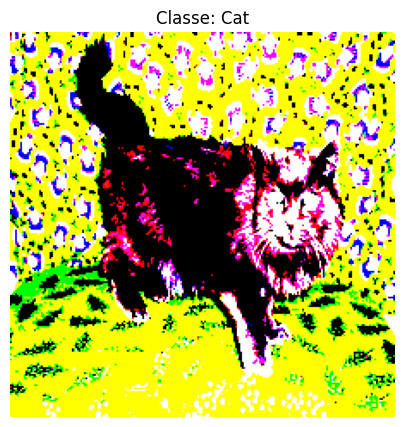

In [ ]:
# BLOCO 8:

# Execução principal
if 'categories' in globals() and len(categories) > 0:
    print("\nIniciando processamento das imagens...")
    dados_gerador, contagem, num_classes = processar_imagens(categories)

    try:
        data = next(dados_gerador)
        if data:
            print("\n🔍 Exemplo do primeiro item:")
            first_item = data[0]
            print(f"Tipo do 'x': {type(first_item['x'])}")
            print(f"Formato do array: {first_item['x'].shape}")
            print(f"Label (y): {first_item['y']} ({categories[first_item['y']].split('/')[-1]})")

            # Visualização
            plt.figure(figsize=(5,5))
            img_to_show = first_item['x'].copy()
            if img_to_show.max() <= 1.0:
                img_to_show = (img_to_show * 255).astype('uint8')
            plt.imshow(img_to_show)
            plt.title(f"Classe: {categories[first_item['y']].split('/')[-1]}")
            plt.axis('off')
            plt.show()
            plt.close()

            # Salva data para uso posterior
            processed_data = data
        else:
            print("⚠️ Nenhum dado processado no primeiro lote!")
    except StopIteration:
        print("⚠️ O gerador não retornou dados!")
else:
    print("❌ Categorias não definidas ou vazias!")

Randomize the data order.

In [ ]:
# BLOCO 9:

if 'processed_data' in globals():
    random.shuffle(processed_data)
    print("\nDados embaralhados com sucesso!")
    print(f"Tamanho do lote: {len(processed_data)}")
else:
    print("⚠️ Nenhum dado disponível para embaralhar!")


Dados embaralhados com sucesso!
Tamanho do lote: 32


In [ ]:
# BLOCO 10:

if 'processed_data' in globals() and len(processed_data) > 0:
    idx_val = int(train_split * len(processed_data))
    idx_test = int((train_split + val_split) * len(processed_data))
    train = processed_data[:idx_val]
    val = processed_data[idx_val:idx_test]
    test = processed_data[idx_test:]
    print(f"Dados divididos - Treino: {len(train)}, Val: {len(val)}, Teste: {len(test)}")
else:
    print("⚠️ Nenhum dado disponível para divisão!")
    train, val, test = [], [], []

Dados divididos - Treino: 22, Val: 5, Teste: 5


Separate data for labels.

In [ ]:
# BLOCO 11:

if train and val and test:
    x_train = np.array([t["x"] for t in train])
    y_train = np.array([t["y"] for t in train])
    x_val = np.array([t["x"] for t in val])
    y_val = np.array([t["y"] for t in val])
    x_test = np.array([t["x"] for t in test])
    y_test = np.array([t["y"] for t in test])

    print("\nAmostra de labels de teste:")
    print(y_test[:5])  # Mostra apenas 5 primeiros para economizar espaço
else:
    print("⚠️ Dados incompletos para preparação dos arrays!")
    x_train, y_train, x_val, y_val, x_test, y_test = [None]*6


Amostra de labels de teste:
[0 0 0 0 0]


In [ ]:
# BLOCO 12:

if x_train is not None:
    # Normalização
    x_train = x_train.astype('float32') / 255.
    x_val = x_val.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # One-hot encoding
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    print("\nShape dos dados de teste após one-hot:")
    print(y_test.shape)
else:
    print("⚠️ Não foi possível normalizar os dados!")


Shape dos dados de teste após one-hot:
(5, 2)


In [ ]:
# BLOCO 13:

if x_train is not None:
    print("\nRESUMO FINAL:")
    print(f"Total de imagens carregadas: {len(x_train)+len(x_val)+len(x_test)}")
    print(f"Categorias: {num_classes}")
    print(f"Divisão (Treino/Val/Teste): {len(x_train)}/{len(x_val)}/{len(x_test)}")
    print(f"Shape dados treino: {x_train.shape}")
    print(f"Shape labels treino: {y_train.shape}")
else:
    print("⚠️ Nenhum dado disponível para resumo!")


RESUMO FINAL:
Total de imagens carregadas: 32
Categorias: 2
Divisão (Treino/Val/Teste): 22/5/5
Shape dados treino: (22, 224, 224, 3)
Shape labels treino: (22, 2)


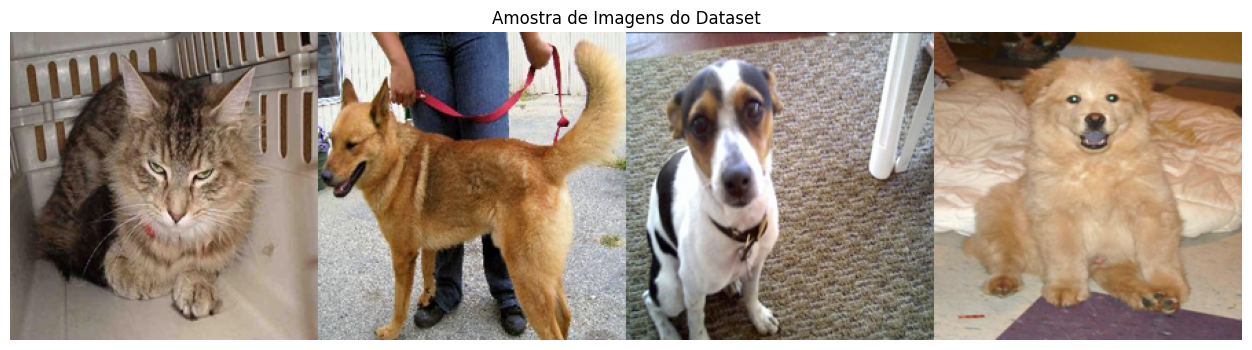

In [ ]:
# BLOCO 14:

try:
    # Carrega apenas 4 imagens para visualização (economiza memória)
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root)
              for f in filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images:
        idx = random.sample(range(len(images)), min(4, len(images)))  # Apenas 4 imagens aleatórias
        imgs = [Image.open(images[i]).resize((224, 224)) for i in idx]

        plt.figure(figsize=(16,4))
        plt.imshow(np.concatenate([np.asarray(img) for img in imgs], axis=1))
        plt.title("Amostra de Imagens do Dataset")
        plt.axis('off')
        plt.show()
    else:
        print("⚠️ Nenhuma imagem encontrada para visualização!")
except Exception as e:
    print(f"Erro na visualização: {str(e)}")

In [ ]:
# BLOCO 15:

if x_train is not None:
    input_shape = x_train.shape[1:]
    print(f"\nDimensões de entrada: {input_shape}")

    model = Sequential()

    # Arquitetura otimizada
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.summary()
else:
    print("⚠️ Não é possível construir o modelo sem dados de treino!")
    model = None


Dimensões de entrada: (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,709,890 (98.08 MB)

 Trainable params: 25,709,890 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# BLOCO 16:

if model and x_train is not None:
    # Compilação com learning rate reduzido
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

    # Callbacks para evitar overfitting
    callbacks = [
        keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]

    print("\nIniciando treinamento...")
    history = model.fit(
        x_train, y_train,
        batch_size=64,  # Reduzido para economizar memória
        epochs=15,     # Aumentado com early stopping
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
else:
    print("⚠️ Modelo ou dados não disponíveis para treinamento!")
    history = None


Iniciando treinamento...
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4545 - loss: 0.7129 - val_accuracy: 1.0000 - val_loss: 0.0345 - learning_rate: 1.0000e-04
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0260 - val_accuracy: 1.0000 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 5.5029e-04 - learning_rate: 1.0000e-04
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 8.1255e-04 - val_accuracy: 1.0000 - val_loss: 1.1033e-04 - learning_rate: 1.0000e-04
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.5652e-04 - val_accuracy: 1.0000 - val_loss: 2.7465e-05 - learning_rate: 1.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 9.6584e-05 - val_accuracy: 1.0000 - val_loss: 8.1062e-06 - learning_rate: 1.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━

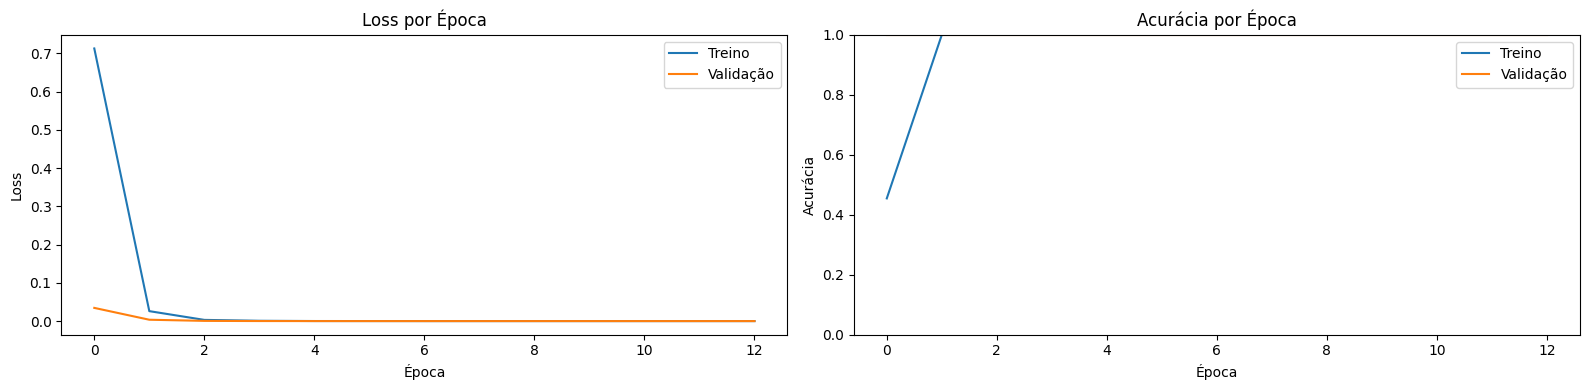

In [ ]:
# BLOCO 17:

if history:
    plt.figure(figsize=(16,4))

    # Gráfico de Loss
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de Acurácia
    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Nenhum histórico de treinamento disponível!")

In [ ]:
# BLOCO 18:

if model is not None and x_test is not None:
    print("\nAvaliando modelo básico...")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
else:
    print("⚠️ Modelo ou dados de teste não disponíveis para avaliação!")


Avaliando modelo básico...
Test loss: 0.0
Test accuracy: 1.0


In [ ]:
# BLOCO 19:

try:
    print("\nCarregando VGG16 pré-treinado...")
    vgg = keras.applications.VGG16(weights='imagenet',
                                  include_top=True,
                                  input_shape=x_train.shape[1:])
    vgg.summary()
except Exception as e:
    print(f"Erro ao carregar VGG16: {str(e)}")
    vgg = None


Carregando VGG16 pré-treinado...


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# BLOCO 20:

if vgg is not None:
    try:
        print("\nPreparando modelo para transfer learning...")
        # Cria novo modelo mantendo as camadas do VGG exceto a última
        inp = vgg.input
        new_classification_layer = Dense(num_classes, activation='softmax')

        # Conecta a nova camada à penúltima do VGG
        out = new_classification_layer(vgg.layers[-2].output)

        model_new = Model(inputs=inp, outputs=out)
        print("Modelo para transfer learning criado com sucesso!")
    except Exception as e:
        print(f"Erro ao criar modelo de transfer learning: {str(e)}")
        model_new = None
else:
    model_new = None


Preparando modelo para transfer learning...
Modelo para transfer learning criado com sucesso!


In [ ]:
# BLOCO 21:

if model_new is not None:
    print("\nConfigurando camadas para transfer learning...")
    # Congela todas as camadas exceto a última
    for layer in model_new.layers[:-1]:
        layer.trainable = False

    # Compila com learning rate menor
    model_new.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print("Última camada treinável:")
    model_new.summary()
else:
    print("⚠️ Modelo não disponível para configuração!")


Configurando camadas para transfer learning...
Última camada treinável:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [ ]:
# BLOCO 22:

if model_new is not None and x_train is not None:
    print("\nIniciando transfer learning...")
    callbacks = [
        keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        keras.callbacks.ModelCheckpoint('best_transfer.h5', save_best_only=True)
    ]

    history2 = model_new.fit(
        x_train, y_train,
        batch_size=32,  # Batch menor para transfer learning
        epochs=15,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
else:
    print("⚠️ Dados ou modelo não disponíveis para treinamento!")
    history2 = None


Iniciando transfer learning...
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 1.0000 - loss: 0.1008

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 1.0000 - loss: 0.1008 - val_accuracy: 1.0000 - val_loss: 0.0636
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 1.0000 - loss: 0.0692

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 1.0000 - loss: 0.0692 - val_accuracy: 1.0000 - val_loss: 0.0433
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 1.0000 - loss: 0.0478

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 1.0000 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 0.0299
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 1.0000 - loss: 0.0333

1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - accuracy: 1.0000 - loss: 0.0333 - val_accuracy: 1.0000 - val_loss: 0.0210
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 1.0000 - loss: 0.0237

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 1.0000 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0150
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 0.0171

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 1.0000 - loss: 0.0126

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0095

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - loss: 0.0073

1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 1.0000 - loss: 0.0057

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0046

1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 1.0000 - loss: 0.0037

1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0031

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 1.0000 - loss: 0.0026

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 1.0000 - loss: 0.0022

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0016


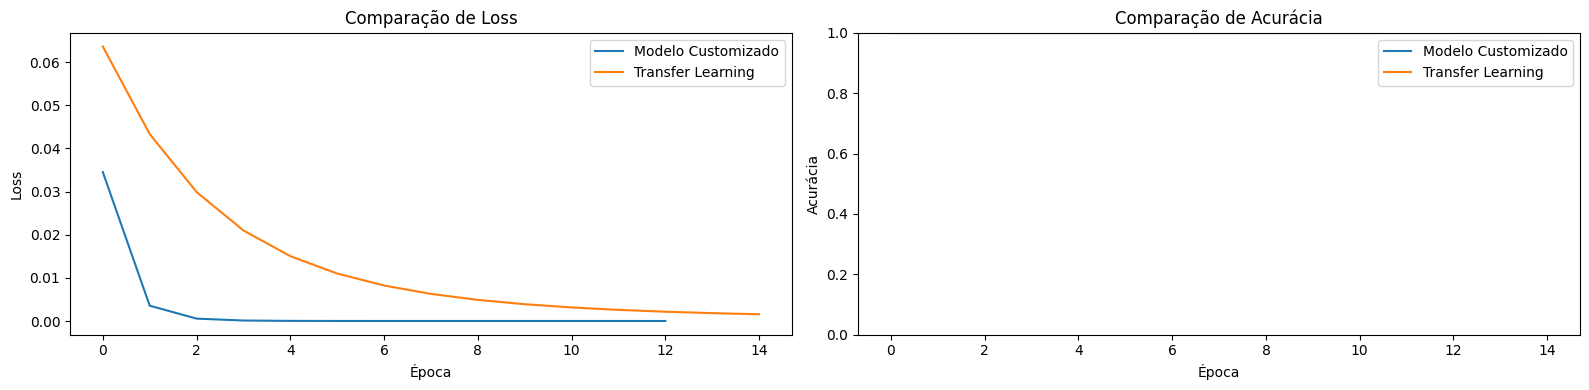

In [ ]:
# BLOCO 23:

if history and history2:
    plt.figure(figsize=(16,4))

    # Loss
    plt.subplot(121)
    plt.plot(history.history['val_loss'], label='Modelo Customizado')
    plt.plot(history2.history['val_loss'], label='Transfer Learning')
    plt.title('Comparação de Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # Acurácia
    plt.subplot(122)
    plt.plot(history.history['val_accuracy'], label='Modelo Customizado')
    plt.plot(history2.history['val_accuracy'], label='Transfer Learning')
    plt.title('Comparação de Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Históricos incompletos para comparação!")

In [ ]:
# BLOCO 24:

if model_new is not None and x_test is not None:
    print("\nAvaliando modelo com transfer learning...")
    loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)

    # Comparação com modelo básico
    if model is not None:
        base_loss, base_acc = model.evaluate(x_test, y_test, verbose=0)
        print(f"\nMelhoria de {(accuracy-base_acc)*100:.2f}% na acurácia")
else:
    print("⚠️ Modelo ou dados de teste não disponíveis!")


Avaliando modelo com transfer learning...
Test loss: 0.0019960994832217693
Test accuracy: 1.0

Melhoria de 0.00% na acurácia



Testando predição para: PetImages/Cat/1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


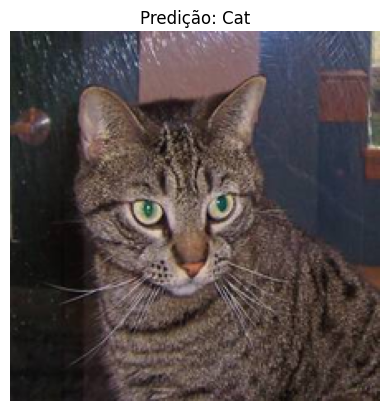

Probabilidades por classe:
Cat: 0.9687
Dog: 0.0313


In [ ]:
# BLOCO 25:

test_image_path = 'PetImages/Cat/1.jpg'  # Exemplo - altere conforme necessário

if os.path.exists(test_image_path):
    try:
        print(f"\nTestando predição para: {test_image_path}")
        x, img = get_image(test_image_path)

        if x is not None:
            # Prepara input para o modelo (adiciona dimensão do batch)
            x = np.expand_dims(x, axis=0)

            # Predição
            probabilities = model_new.predict(x)
            predicted_class = np.argmax(probabilities)

            # Mostra resultado
            plt.imshow(img)
            plt.title(f"Predição: {categories[predicted_class].split('/')[-1]}")
            plt.axis('off')
            plt.show()

            print("Probabilidades por classe:")
            for i, prob in enumerate(probabilities[0]):
                print(f"{categories[i].split('/')[-1]}: {prob:.4f}")
        else:
            print("⚠️ Não foi possível processar a imagem!")
    except Exception as e:
        print(f"Erro durante predição: {str(e)}")
else:
    print(f"⚠️ Arquivo de teste não encontrado: {test_image_path}")
    print("Dica: Verifique se o caminho está correto ou substitua por uma imagem existente")